<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/correlation/folder/Correlation_IN10_interest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import datetime

In [25]:
data = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/data4correlation/in10.csv')

In [26]:
data['date']=data.time.apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%d-%m-%Y'))

In [27]:
del data['time']

In [28]:
data= data.set_index('date')

In [29]:
data=data['01-01-2018':]

In [30]:
data_subset = data[['close','IN10, TVC: Close']]

In [31]:
data_subset.tail(2)

,close,"IN10, TVC: Close"
date,,
24-08-2021,16624.60,98.90
25-08-2021,16634.65,98.94


In [32]:
data_subset.columns=['close','close1']

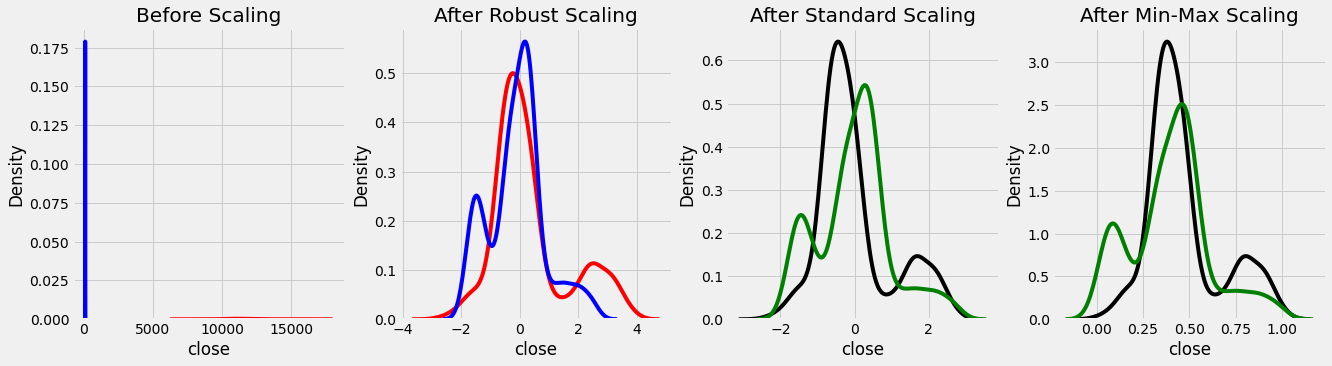

In [33]:
# Importing libraries
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
% matplotlib inline
matplotlib.style.use('fivethirtyeight')

# data
x = data_subset
scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns =['close','close1'])

scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns =['close','close1'])

scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(x)
minmax_df = pd.DataFrame(minmax_df, columns =['close','close1'])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')

sns.kdeplot(x['close'], ax = ax1, color ='r')
sns.kdeplot(x['close1'], ax = ax1, color ='b')
ax2.set_title('After Robust Scaling')

sns.kdeplot(robust_df['close'], ax = ax2, color ='red')
sns.kdeplot(robust_df['close1'], ax = ax2, color ='blue')
ax3.set_title('After Standard Scaling')

sns.kdeplot(standard_df['close'], ax = ax3, color ='black')
sns.kdeplot(standard_df['close1'], ax = ax3, color ='g')
ax4.set_title('After Min-Max Scaling')

sns.kdeplot(minmax_df['close'], ax = ax4, color ='black')
sns.kdeplot(minmax_df['close1'], ax = ax4, color ='g')
plt.show()


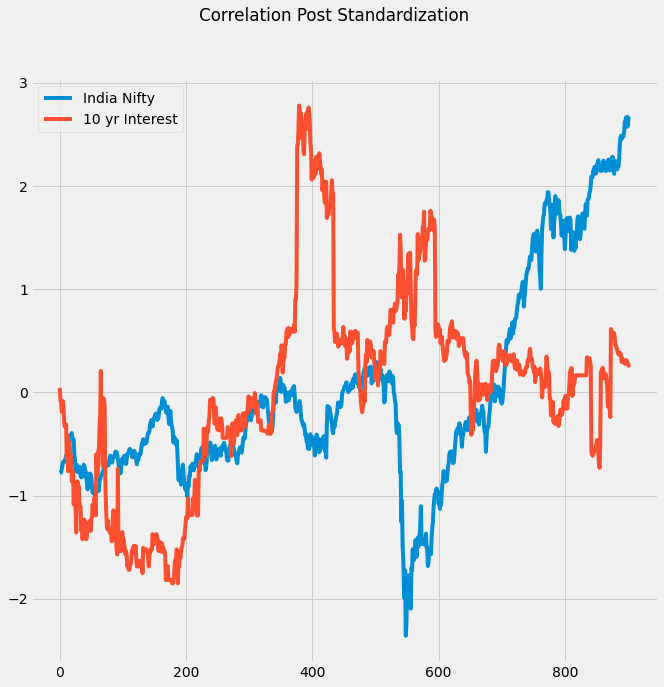

In [34]:
columns=['India Nifty','10 yr Interest']
standard_df=standard_df.fillna(method='ffill')
standard_df.columns=columns
standard_df[-1200:].plot(figsize=(10,10))
plt.suptitle('Correlation Post Standardization')
plt.show()

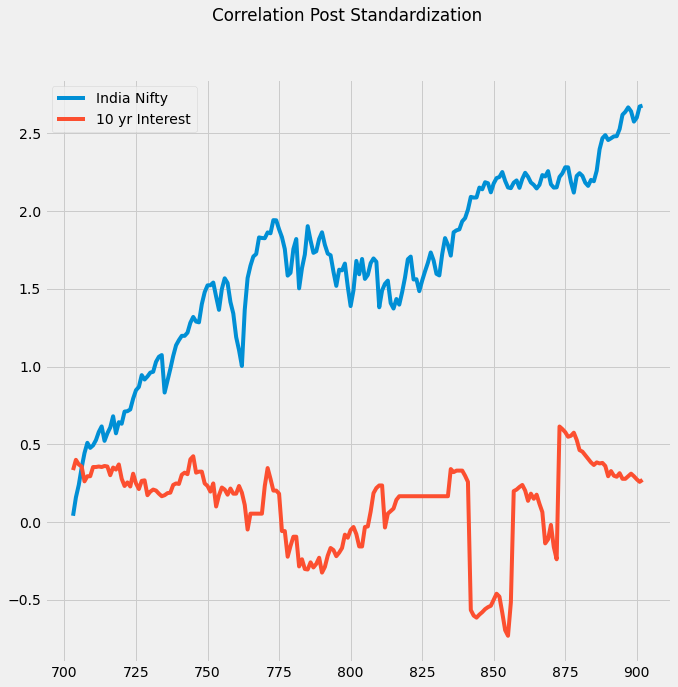

In [35]:
columns=['India Nifty','10 yr Interest']
standard_df.columns=columns
standard_df[-200:].plot(figsize=(10,10))
plt.suptitle('Correlation Post Standardization')
plt.show()

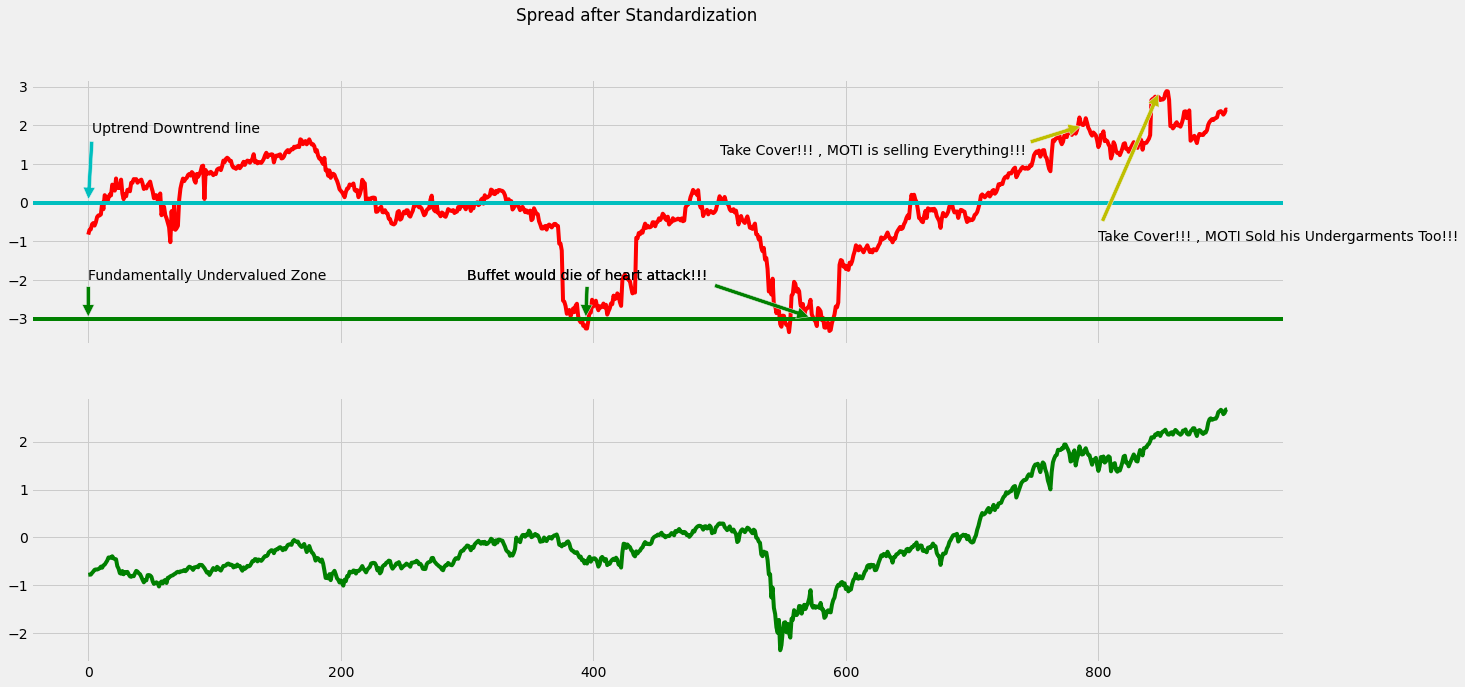

In [36]:
standard_df['diff']=standard_df['India Nifty']-standard_df['10 yr Interest']

plt.rcParams["figure.figsize"] = (20,10)
fig,ax=plt.subplots(2,1,sharex=True)
ax[0].plot(standard_df['diff'],color='r')
ax[1].plot(standard_df['India Nifty'],color='g')
ax[0].axhline(y=0,color='c')
ax[0].axhline(y=-3,color='g')
plt.suptitle('Spread after Standardization')
ax[0].annotate('Uptrend Downtrend line', xy =(0, 0),
             xytext =(3, 1.8),
             arrowprops = dict(facecolor ='c',
                               shrink = 0.05),   )
ax[0].annotate('Fundamentally Undervalued Zone ', xy =(0, -3),
             xytext =(0, -2),
             arrowprops = dict(facecolor ='g',
                               shrink = 0.05),   )
ax[0].annotate('Buffet would die of heart attack!!!', xy =(394, -3),
             xytext =(300, -2),
             arrowprops = dict(facecolor ='g',
                               shrink = 0.05),   )
ax[0].annotate('Buffet would die of heart attack!!!', xy =(575, -3),
             xytext =(300, -2),
             arrowprops = dict(facecolor ='g',
                               shrink = 0.05),   )
ax[0].annotate('Take Cover!!! , MOTI is selling Everything!!!', xy =(788, 2),
             xytext =(500, 1.25),
             arrowprops = dict(facecolor ='y',
                               shrink = 0.05),   )
ax[0].annotate('Take Cover!!! , MOTI Sold his Undergarments Too!!!', xy =(850, 3),
             xytext =(800, -1),
             arrowprops = dict(facecolor ='y',
                               shrink = 0.05),   )
plt.show()

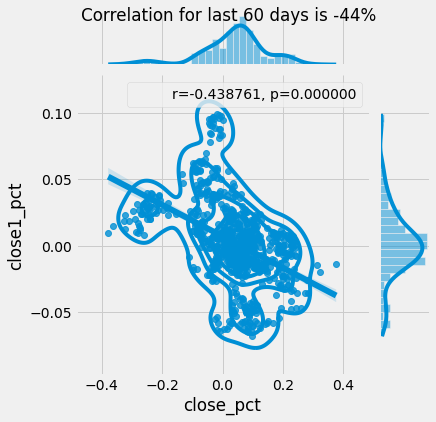

In [37]:
data_subset['close_pct']=data_subset['close'].pct_change(60)
data_subset['close1_pct']=data_subset['close1'].pct_change(60)

data_subset.dropna(inplace=True)
g=sns.jointplot(x='close_pct',y='close1_pct',data=data_subset,kind='reg').plot_joint(sns.kdeplot,n_levels=6)
r, p = pearsonr(data_subset['close_pct'], data_subset['close1_pct'])
phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
g.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
plt.suptitle(f'Correlation for last 60 days is {round(r*100)}%')
plt.show()